In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj,get_prop_abs, create_R
from setup import setup_matplotlib
#from scipy.linalg import expm
#from scipy.sparse import csr_array, coo_array
from scipy.optimize import curve_fit

setup_matplotlib()

np.random.seed(42)

In [8]:
k = 1
s = 0.5
border = 1
N_x_border = 5.5
max_t = 10
ntau = 3

D = s**2/2

dx = border/N_x_border
sb = 3
sb -= sb%dx
print(sb)

f = 15
N_p = 16_000


x_s = np.arange(-sb,border-dx/4,dx) #don't include border !
bins = np.arange(-sb-dx/2,border+dx/4,dx)
N_x = len(x_s)
print(N_x, len(bins))



def force(x,*args):
     return -k*x

i_zero = np.argmin((x_s)**2)


#ltaus = np.concatenate(([0.05], np.arange(0.2,2.2,0.2) ))
ltaus = np.array([0.2])

2.909090909090909
22 23


In [9]:
x_s, bins

(array([-2.90909091e+00, -2.72727273e+00, -2.54545455e+00, -2.36363636e+00,
        -2.18181818e+00, -2.00000000e+00, -1.81818182e+00, -1.63636364e+00,
        -1.45454545e+00, -1.27272727e+00, -1.09090909e+00, -9.09090909e-01,
        -7.27272727e-01, -5.45454545e-01, -3.63636364e-01, -1.81818182e-01,
        -2.66453526e-15,  1.81818182e-01,  3.63636364e-01,  5.45454545e-01,
         7.27272727e-01,  9.09090909e-01]),
 array([-3.        , -2.81818182, -2.63636364, -2.45454545, -2.27272727,
        -2.09090909, -1.90909091, -1.72727273, -1.54545455, -1.36363636,
        -1.18181818, -1.        , -0.81818182, -0.63636364, -0.45454545,
        -0.27272727, -0.09090909,  0.09090909,  0.27272727,  0.45454545,
         0.63636364,  0.81818182,  1.        ]))

In [10]:
num_rates = np.empty((len(ltaus),2))
sim_rates = np.empty((len(ltaus),2))

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau
    N_t = max(int(max_t/ldt), 30)
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx)
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=0, force=force)
    pos_abs = pos[0].copy()
    for i in range(ntau+1, pos.shape[-1]):
        pos_abs[pos_abs[:,i] > 1,i:] = np.nan
    
    sim_hists = np.stack([np.histogram(pos_abs[:,j], bins = bins)[0] for j in tqdm(range(pos_abs.shape[-1]), leave=False)])
    
    ts = np.arange(0,N_t)*ldt
    sim_ts = np.arange(0,f*N_t+ntau*f)*ldt/f-ltau

    num_sur = np.sum(hists, axis = 1)
    sim_sur = np.sum(sim_hists, axis = 1)/N_p
    
    
    #num_rates[i] = (ts[np.argmin((num_sur-0.75)**2)], num_sur[np.argmin((num_sur-0.75)**2)])
    #sim_rates[i] = (sim_ts[np.argmin((sim_sur-0.75)**2)], sim_sur[np.argmin((sim_sur-0.75)**2)])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/2249 [00:00<?, ?it/s]

  0%|          | 0/2295 [00:00<?, ?it/s]

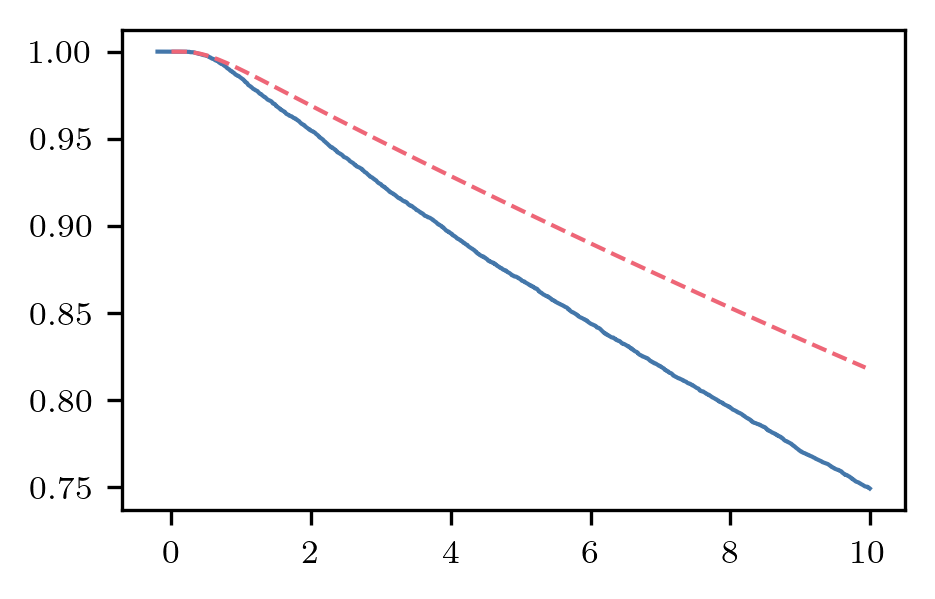

In [11]:
plt.plot(sim_ts, sim_sur)
plt.plot(ts, num_sur, '--')

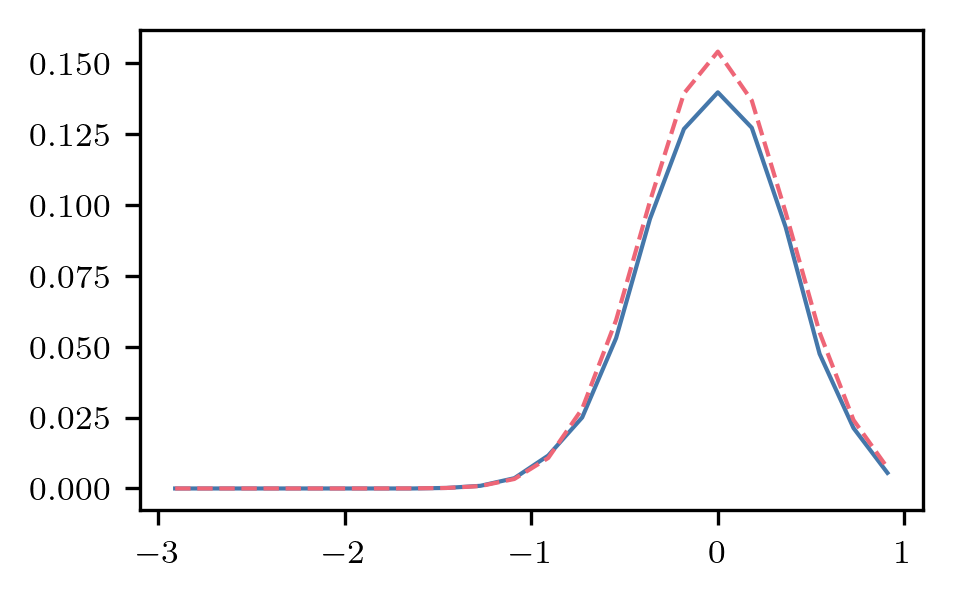

In [12]:
idx = len(hists)-1
plt.plot(x_s,sim_hists[(idx+ntau)*f]/N_p)
plt.plot(x_s,hists[idx], '--')